## CFSR Data and Graphics Preparation for the Science-on-a-Sphere

This notebook will create all the necessary files and directories for a visualization on NOAA's Science-on-a-Sphere. For this example, we will produce a map of 850 hPa geopotential heights, temperature, and horizontal wind and sea-level pressure, using the Climate Forecast System Reanalysis (CFSR), for the March 13-14 1993 winter storm, aka **Superstorm '93**.

<div class="alert alert-info"><b>Note: </b>This notebook is an update of the one we discussed in the April 11 class. Besides some code edits to improve the look of the plots and overall workflow, it also strips out the cells that illustrate the utility of the <code>add_cyclic_point</code> function.</div>

## Overview:

1. Set up output directories for SoS
1. Specify the date/time range for your case
1. Use Cartopy's `add_cyclic_point` method to avoid a blank seam at the dateline
1. Create small and large thumbnail graphics.
1. Create a standalone colorbar
1. Create a set of labels for each plot
1. Create 24 hours worth of Science-on-a-Sphere-ready plots
1. Create an SoS playlist file


## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| Matplotlib  | Necessary | |
| Cartopy  | Necessary | |
| Xarray  | Necessary | |
| Metpy  | Necessary | |
| Linux command line / directory structure | Helpful | |

* **Time to learn**: 30 minutes
***

## Imports

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util as cutil
from datetime import datetime as dt
import warnings
import metpy.calc as mpcalc
from metpy.units import units
import matplotlib.pyplot as plt

Do not output warning messages

In [2]:
warnings.simplefilter("ignore")

## Set up output directories for SoS

The software that serves output for the Science-on-a-Sphere expects a directory structure as follows:
- Top level directory: choose a name that is consistent with your case, e.g.: **SS93**
- 2nd level directory: choose a name that is consistent with the graphic, e.g.: **SLP_500Z**
- 3rd level directories: 
    - **2048**: Contains the graphics (resolution: 2048x1024) that this notebook generates
    - **labels**: Contains one or two files:
        1. (required) A text file, `labels.txt`, which has as many lines as there are graphics in the **2048** file. Each line functions as the title of each graphic. 
        1. (optional) A PNG file, `colorbar.png`, which colorbar which will get overlaid on your map graphic.
    - **media**: Contains large and small thumbnails (`thumbnail_small.jpg`, `thumbnail_large.jpg`) that serve as icons on the SoS iPad and SoS computer apps
    - **playlist**: A text file, `playlist.sos`, which tells the SoS how to display your product
    
As an example, here is how the directory structure on our SoS looks for the products generated by this notebook. Our SoS computer stores locally-produced content in the `/shared/sos/media/site-custom` directory (note: the SoS directories are not network-accessible, so you won't be able to `cd` into them). The CFSR visualizations go in the `CFSR` subfolder. Your top-level directory sits within the `CFSR` folder.

```
sos@sos1:/shared/sos/media/site-custom/CFSR/cle_superbomb/SLP_500Z$ ls -R
.:
2048  labels  media  playlist

./2048:
CFSR_1978012600-fs8.png  CFSR_1978012606-fs8.png  CFSR_1978012612-fs8.png  CFSR_1978012618-fs8.png
CFSR_1978012601-fs8.png  CFSR_1978012607-fs8.png  CFSR_1978012613-fs8.png  CFSR_1978012619-fs8.png
CFSR_1978012602-fs8.png  CFSR_1978012608-fs8.png  CFSR_1978012614-fs8.png  CFSR_1978012620-fs8.png
CFSR_1978012603-fs8.png  CFSR_1978012609-fs8.png  CFSR_1978012615-fs8.png  CFSR_1978012621-fs8.png
CFSR_1978012604-fs8.png  CFSR_1978012610-fs8.png  CFSR_1978012616-fs8.png  CFSR_1978012622-fs8.png
CFSR_1978012605-fs8.png  CFSR_1978012611-fs8.png  CFSR_1978012617-fs8.png  CFSR_1978012623-fs8.png

./labels:
colorbar.png  labels.txt

./media:
thumbnail_big.jpg  thumbnail_small.jpg

./playlist:
playlist.sos
```

Define the 1st and 2nd-level directories.

In [3]:
# You define these
caseDir = 'SS1993'
prodDir = '850T_Z_Wind'

The 3rd-level directories follow from the 1st and 2nd.

In [4]:
# These remain as is
graphicsDir = caseDir + '/' + prodDir + '/2048/'
labelsDir = caseDir + '/' + prodDir + '/labels/'
mediaDir = caseDir + '/' + prodDir + '/media/'
playlistDir = caseDir + '/' + prodDir + '/playlist/'

Create these directories via a Linux command

In [5]:
! mkdir -p {graphicsDir} {labelsDir} {mediaDir} {playlistDir}

<div class="alert alert-info"><b>Note: </b>In a Jupyter notebook, the <code>!</code> magic indicates that what follows is a Linux command.<br>
The <code>-p</code> option for <code>mkdir</code> will create all subdirectories, and also will do nothing if the directories already exist.</div>

<div class="alert alert-danger"><b>Note: </b>The next cell will remove all PNGs in the graphics directory, as will typically be necessary if you have made any changes to the file names or number of frames. <i>Comment this cell out if you don't want to do this!</i></div>

In [6]:
# Remove all PNGs in the graphics directory - COMMENT OUT if you don't want to do this!
! rm -f  {graphicsDir}*.png

## 1) Specify a starting and ending date/time, and access several CFSR Datasets

<div class="alert alert-info"><b>Note: </b>The sphere animation will be more effective with at least a minimum number of frames. Since the CFSR has a timestep of 6 hours (4x/day), let's extend our time range to 7 days ... i.e. 28 frames.</div>

In [7]:
# Date/Time specification
startYear = 1993
startMonth = 3
startDay = 9
startHour = 0
startMinute = 0
startDateTime = dt(startYear,startMonth,startDay, startHour, startMinute)
startDateTimeStr = dt.strftime(startDateTime, format="%Y%m%d")

endYear = 1993
endMonth = 3
endDay = 15
endHour = 18
endMinute = 0
endDateTime = dt(endYear,endMonth,endDay, endHour, endMinute)

### Create Xarray Dataset objects, each pointing to their respective NetCDF files in the /cfsr/data directory tree, using Xarray’s open_dataset method.¶

In [8]:
dsZ = xr.open_dataset (f'/cfsr/data/{startYear}/g.{startYear}.0p5.anl.nc')
dsT = xr.open_dataset (f'/cfsr/data/{startYear}/t.{startYear}.0p5.anl.nc')
dsU = xr.open_dataset (f'/cfsr/data/{startYear}/u.{startYear}.0p5.anl.nc')
dsV = xr.open_dataset (f'/cfsr/data/{startYear}/v.{startYear}.0p5.anl.nc')
#dsW = xr.open_dataset (f'/cfsr/data/{startYear}/w.{startYear}.0p5.anl.nc')
#dsQ = xr.open_dataset (f'/cfsr/data/{startYear}/q.{startYear}.0p5.anl.nc')
#dsSLP = xr.open_dataset (f'/cfsr/data/{startYear}/pmsl.{startYear}.0p5.anl.nc')

Subset the desired Datasets along their temporal and (if applicable) vertical dimensions. **Since we will be displaying over the entire globe, we will not subset over latitudes nor longitudes!**

In [9]:
dateList = pd.date_range(startDateTime, endDateTime,freq="6H")
dateList

DatetimeIndex(['1993-03-09 00:00:00', '1993-03-09 06:00:00',
               '1993-03-09 12:00:00', '1993-03-09 18:00:00',
               '1993-03-10 00:00:00', '1993-03-10 06:00:00',
               '1993-03-10 12:00:00', '1993-03-10 18:00:00',
               '1993-03-11 00:00:00', '1993-03-11 06:00:00',
               '1993-03-11 12:00:00', '1993-03-11 18:00:00',
               '1993-03-12 00:00:00', '1993-03-12 06:00:00',
               '1993-03-12 12:00:00', '1993-03-12 18:00:00',
               '1993-03-13 00:00:00', '1993-03-13 06:00:00',
               '1993-03-13 12:00:00', '1993-03-13 18:00:00',
               '1993-03-14 00:00:00', '1993-03-14 06:00:00',
               '1993-03-14 12:00:00', '1993-03-14 18:00:00',
               '1993-03-15 00:00:00', '1993-03-15 06:00:00',
               '1993-03-15 12:00:00', '1993-03-15 18:00:00'],
              dtype='datetime64[ns]', freq='6H')

Set a variable corresponding to the number of times in the desired time range

In [10]:
nTimes = len(dateList)
nTimes

28

In [11]:
# Vertical level specificaton
pLevel = 850
levelStr = f'{pLevel}' # Use for the figure title


# Data variable selection; modify depending on what variables you are interested in

T = dsT['t'].sel(time=dateList,lev=pLevel)
U = dsU['u'].sel(time=dateList,lev=pLevel)
V = dsV['v'].sel(time=dateList,lev=pLevel)
Z = dsZ['g'].sel(time=dateList,lev=pLevel)

### Examine the datasets

In [12]:
T

<xarray.DataArray 't' (time: 28, lat: 361, lon: 720)>
[7277760 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1993-03-09 ... 1993-03-15T18:00:00
  * lat      (lat) float32 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float32 -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
    lev      float32 850.0
Attributes:
    level_type:  isobaric_level (hPa)
    units:       K
    long_name:   temperature

In [13]:
U

<xarray.DataArray 'u' (time: 28, lat: 361, lon: 720)>
[7277760 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1993-03-09 ... 1993-03-15T18:00:00
  * lat      (lat) float32 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float32 -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
    lev      float32 850.0
Attributes:
    level_type:  isobaric_level (hPa)
    units:       m s^-1
    long_name:   zonal wind

In [14]:
Z

<xarray.DataArray 'g' (time: 28, lat: 361, lon: 720)>
[7277760 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1993-03-09 ... 1993-03-15T18:00:00
  * lat      (lat) float32 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float32 -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
    lev      float32 850.0
Attributes:
    level_type:  isobaric_level (hPa)
    units:       gpm
    long_name:   height

Perform unit conversions

In [15]:
Z = Z.metpy.convert_units('dam')
U = U.metpy.convert_units('kts')
V = V.metpy.convert_units('kts')
T = T.metpy.convert_units('degC')

Set contour levels for T, after first inspecting its range of values.

In [16]:
T.min(),T.max()

(<xarray.DataArray 't' ()>
 <Quantity(-45.54998779296875, 'degree_Celsius')>
 Coordinates:
     lev      float32 850.0,
 <xarray.DataArray 't' ()>
 <Quantity(35.25, 'degree_Celsius')>
 Coordinates:
     lev      float32 850.0)

In [17]:
tLevels = np.arange(-45,39,3)

For the purposes of plotting geopotential heights in decameters, choose an appropriate contour interval and range of values ... for geopotential heights, a common convention is: from surface up through 700 hPa: 3 dam; above that, 6 dam to 400 and then 9 or 12 dam from 400 and above.

In [18]:
if (pLevel == 1000):
    zLevels= np.arange(-90,63, 3)
elif (pLevel == 850):
    zLevels = np.arange(60, 183, 3)
elif (pLevel == 700):
    zLevels = np.arange(201, 339, 3)
elif (pLevel == 500):
    zLevels = np.arange(468, 606, 6)
elif (pLevel == 300):
    zLevels = np.arange(765, 1008, 9)
elif (pLevel == 200): 
    zLevels = np.arange(999, 1305, 9)

Create objects for the relevant coordinate arrays; in this case, *longitude*, *latitude*, and *time*.

In [19]:
lons, lats, times= T.lon, T.lat, T.time

Take a peek at a couple of these coordinate arrays.

In [20]:
lons

<xarray.DataArray 'lon' (lon: 720)>
array([-180. , -179.5, -179. , ...,  178.5,  179. ,  179.5], dtype=float32)
Coordinates:
  * lon      (lon) float32 -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
    lev      float32 850.0
Attributes:
    actual_range:        [-180.   179.5]
    delta_x:             0.5
    coordinate_defines:  center
    mapping:             cylindrical_equidistant_projection_grid
    grid_resolution:     0.5_degrees
    long_name:           longitude
    units:               degrees_east

<div class="alert alert-warning">Notice that the longitudinal array extends to 179.5, not 180. We will use Cartopy's <code>add_cyclic_point</code> method to eliminate the resulting seam.</div>

In [21]:
times

<xarray.DataArray 'time' (time: 28)>
array(['1993-03-09T00:00:00.000000000', '1993-03-09T06:00:00.000000000',
       '1993-03-09T12:00:00.000000000', '1993-03-09T18:00:00.000000000',
       '1993-03-10T00:00:00.000000000', '1993-03-10T06:00:00.000000000',
       '1993-03-10T12:00:00.000000000', '1993-03-10T18:00:00.000000000',
       '1993-03-11T00:00:00.000000000', '1993-03-11T06:00:00.000000000',
       '1993-03-11T12:00:00.000000000', '1993-03-11T18:00:00.000000000',
       '1993-03-12T00:00:00.000000000', '1993-03-12T06:00:00.000000000',
       '1993-03-12T12:00:00.000000000', '1993-03-12T18:00:00.000000000',
       '1993-03-13T00:00:00.000000000', '1993-03-13T06:00:00.000000000',
       '1993-03-13T12:00:00.000000000', '1993-03-13T18:00:00.000000000',
       '1993-03-14T00:00:00.000000000', '1993-03-14T06:00:00.000000000',
       '1993-03-14T12:00:00.000000000', '1993-03-14T18:00:00.000000000',
       '1993-03-15T00:00:00.000000000', '1993-03-15T06:00:00.000000000',
       '1993-03-15T12:00:00.000000000', '1993-03-15T18:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1993-03-09 ... 1993-03-15T18:00:00
    lev      float32 850.0
Attributes:
    actual_range:  [1691808. 1700562.]
    last_time:     1993-12-31 18:00:00
    first_time:    1993-1-1 00:00:00
    delta_t:       0000-00-00 06:00:00
    long_name:     initial time

## Create a plot of temperature, wind, and geopotential height.
Let's create a plot for a single time, just to ensure all looks good.

<div class="alert alert-info"><b>Note: </b>The Science on a Sphere treats titles and colorbars as separate layers. Thus, in these next cells we will not generate nor include them in the figure.<br>
Additionally, the sphere expects its graphics to have a resolution of 2048x1024.<br>
Finally, by default, Matplotlib includes a border frame around each <code>Axes</code>. We don't want that included on the sphere-projected graphic either.</div>

In [22]:
timeIdx = 0

Subset the DataArrays for that single time (thus, eliminating the time dimension)

In [23]:
Z0 = Z.isel(time=timeIdx)
T0 = T.isel(time=timeIdx)
U0 = U.isel(time=timeIdx)
V0 = V.isel(time=timeIdx)

In [24]:
proj_data = ccrs.PlateCarree() # The dataset's x- and y- coordinates are lon-lat

<div class="alert alert-note">Use Cartopy's <code>add_cyclic_point</code> function to eliminate the seam at the dateline, and create the map.</div>

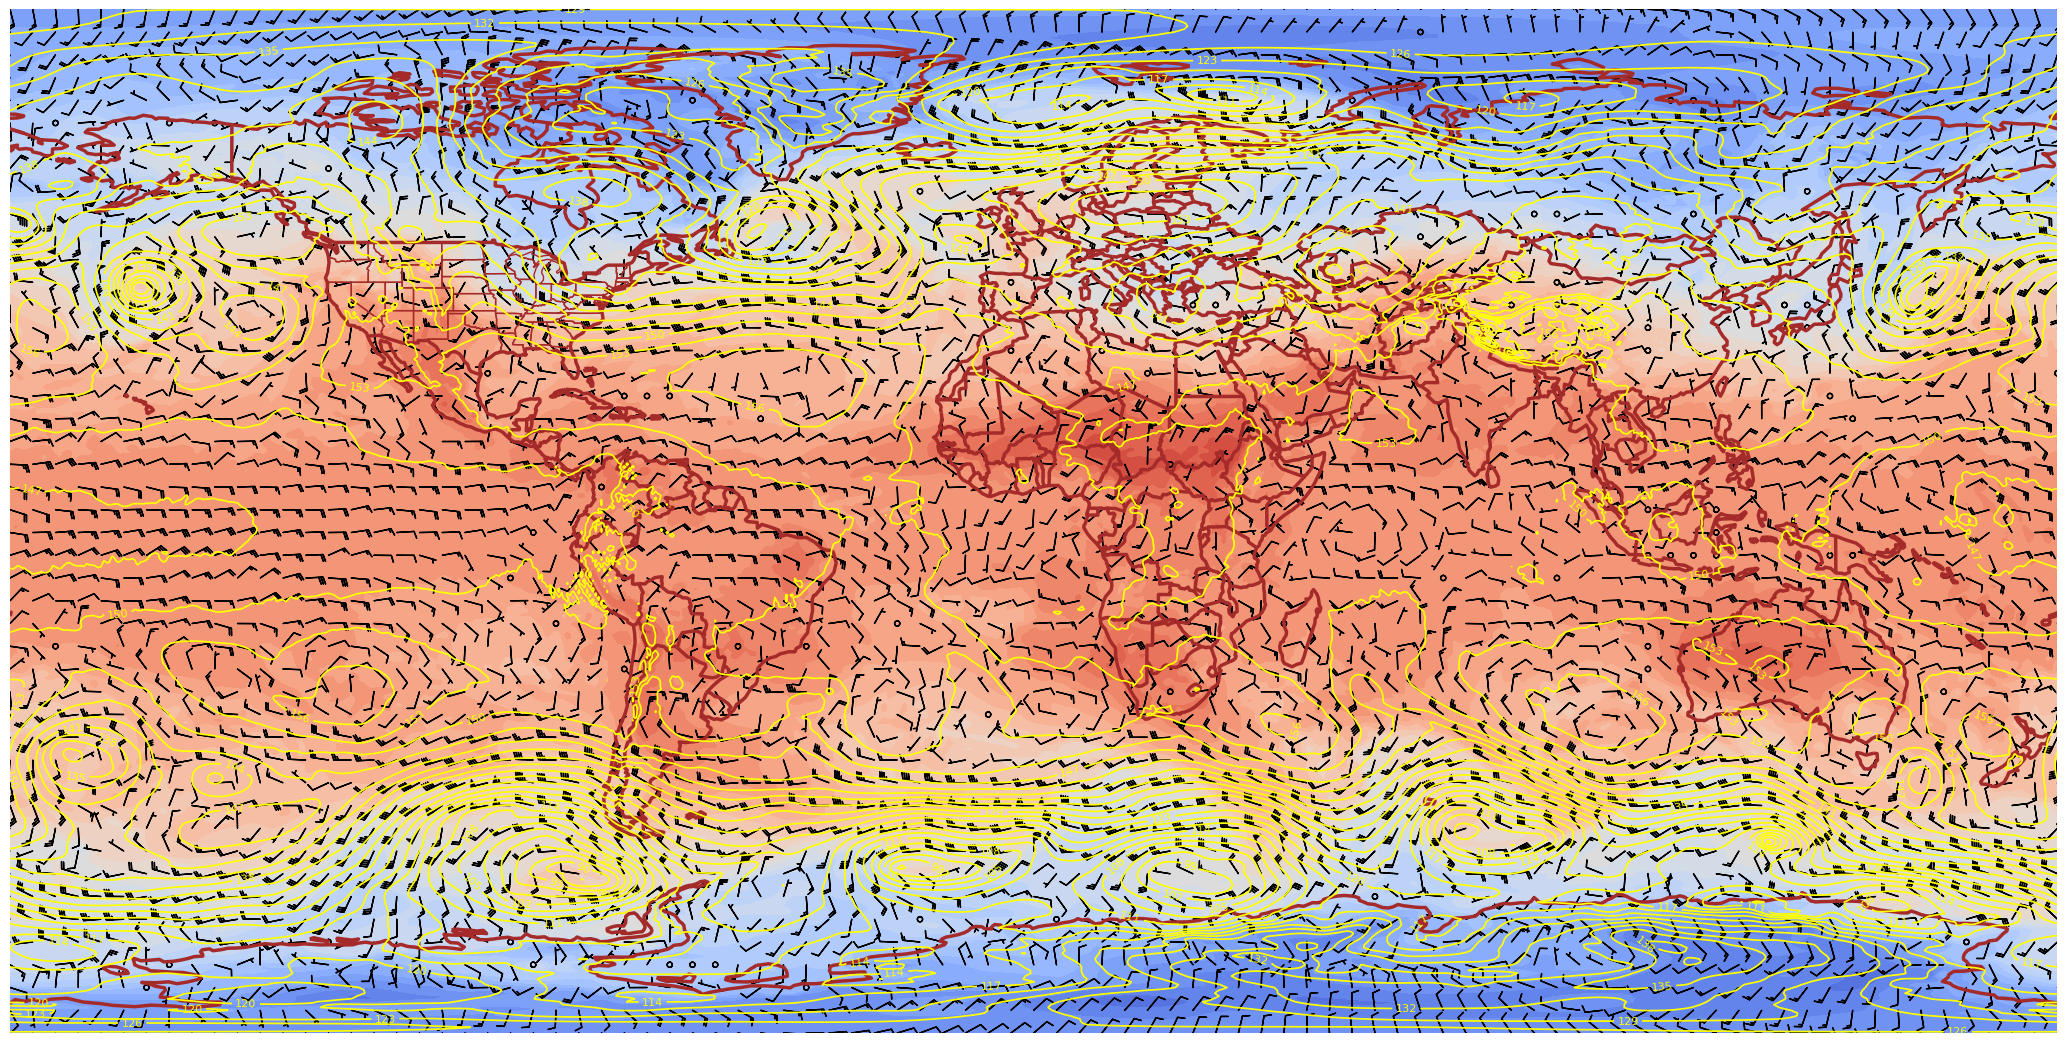

In [25]:
res = '110m'
dpi = 100
fig = plt.figure(figsize=(2048/dpi, 1024/dpi))
ax = plt.subplot(1,1,1,projection=ccrs.PlateCarree(), frameon=False)
ax.set_global()
ax.add_feature(cfeature.COASTLINE.with_scale(res), edgecolor='brown', linewidth=2.5)
ax.add_feature(cfeature.BORDERS.with_scale(res), edgecolor='brown', linewidth=2.5)
ax.add_feature(cfeature.STATES.with_scale(res), edgecolor='brown')

# add cyclic points to data and longitudes
# latitudes are unchanged in 1-dimension
Zcyc, clons = cutil.add_cyclic_point(Z0, lons)
Tcyc, clons = cutil.add_cyclic_point(T0, lons)
Ucyc, clons = cutil.add_cyclic_point(U0, lons)
Vcyc, clons = cutil.add_cyclic_point(V0, lons)

# Temperature (T) contour fills

# Note we don't need the transform argument since the map/data projections are the same, but we'll leave it in
CF = ax.contourf(clons,lats,Tcyc,levels=tLevels,cmap=plt.get_cmap('coolwarm'), extend='both', transform=proj_data) 

# Height (Z) contour lines
CL = ax.contour(clons,lats,Zcyc,zLevels,linewidths=1.25,colors='yellow', transform=proj_data)
ax.clabel(CL, inline_spacing=0.2, fontsize=8, fmt='%.0f')
fig.tight_layout(pad=.01)

# Plotting wind barbs uses the ax.barbs method. Here, you can't pass in the DataArray directly; you can only pass in the array's values.
# Also need to sample (skip) a selected # of points to keep the plot readable.
skip = 8

# The U and V arrays produced by add_cyclic_point do not have units attached, so we do not 
# extract the values attribute as in the previous cells.

# Default length of wind barbs is 7. Shorten them a bit.
ax.barbs(clons[::skip],lats[::skip],Ucyc[::skip,::skip], Vcyc[::skip,::skip], length = 5, transform=proj_data)
# Save this figure to your current directory
fig.savefig('test_CFSR_SOS.png')

## If you'd like, go to https://maptoglobe.com and view how your graphic might look on the sphere.

<div class="alert alert-warning"><b>Note:</b> If you get an error message from the <i>maptoglobe.com</i> site, try reloading. Usually it will load correctly on the 2nd try.<br>
    If it still fails, try <b>http://maptoglobe.com</b></div>

Follow these steps:

1. Download the `test_CFSR_SOS.png` file to your local computer
1. Click on the **Images** tab on the *maptoglobe* site
1. Next to **Surface**, click on *Choose a file*
1. Navigate to the folder in which you downloaded the PNG, select the PNG, and click on **OK**
1. You should then see your map! Use your mouse to move the globe around; also use the mouse wheel to zoom in and out.
1. If the image looks good, you're ready to move forward!

## Create small (128x128) and large (800x800) thumbnails. These will serve as icons in the SoS iPad and computer apps that go along with your particular product.
We'll use the orthographic projection and omit the contour lines and some of the cartographic features, and add a title string.

<div class="alert alert-warning"><b>Note:</b> This cell may take a while to complete. Be patient!</div>

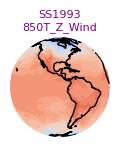

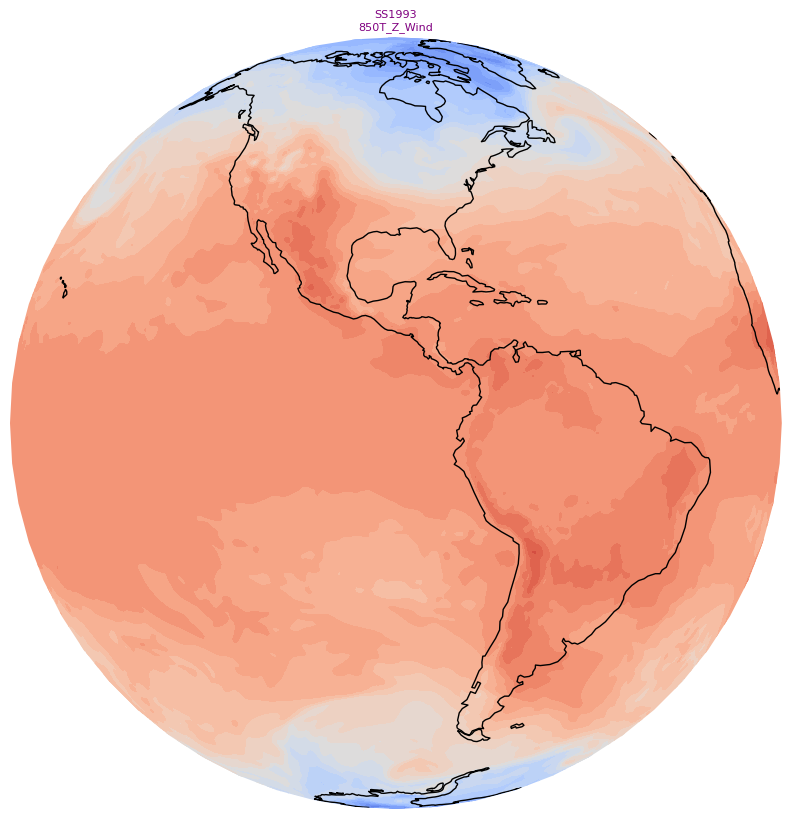

In [26]:
res = '110m'
dpi = 100
for size in (128, 800):
    if (size == 128):
        sizeStr = 'small'
    else:
        sizeStr ='big'
        
    fig = plt.figure(figsize=(size/dpi, size/dpi))
    ax = plt.subplot(1,1,1,projection=ccrs.Orthographic(central_longitude=-90), frameon=False)
    ax.set_global()
    ax.add_feature(cfeature.COASTLINE.with_scale(res))
    tl1 = caseDir
    tl2 = prodDir
    ax.set_title(tl1 + '\n' + tl2, color='purple', fontsize=8)

    # Contour fills

    CF = ax.contourf(clons,lats,Tcyc,levels=tLevels,cmap=plt.get_cmap('coolwarm'), extend='both', transform=proj_data) 

    fig.tight_layout(pad=.01)
    fig.savefig(mediaDir + 'thumbnail_' + sizeStr + '.jpg')

## Create a standalone colorbar
Visualizations on the Science-on-a-Sphere consist of a series of image files, layered on top of each other. In this example, instead of having the colorbar associated with 500 hPa heights adjacent to the map, let's use a technique by which we remove the contour plot, leaving only the colorbar to be exported as an image. We change the colorbar's orientation to horizontal, and also change its tick label colors so they will be more visible on the sphere's display.

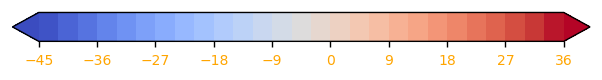

In [27]:
# draw a new figure and replot the colorbar there
fig,ax = plt.subplots(figsize=(14,2), dpi=125)
# set tick and ticklabel color
tick_color='black'
label_color='orange'
cbar = fig.colorbar(CF, ax=ax, orientation='horizontal')
cbar.ax.xaxis.set_tick_params(color=tick_color, labelcolor=label_color, labelsize=8)
# Remove the Axes object ... essentially the contours and cartographic features ... from the figure.
ax.remove()
# All that remains is the colorbar ... save it to disk. Make the background transparent.
fig.savefig(labelsDir + 'colorbar.png',transparent=True)

## Create a set of labels for each plot

In [28]:
labelFname = labelsDir + 'labels.txt'

## Define a function to create the plot for each hour. 
The function accepts a time array element as its argument.

In [29]:
def make_sos_map (timeIdx):
    
    res = '110m'
    dpi = 100
    fig = plt.figure(figsize=(2048/dpi, 1024/dpi))
    ax = plt.subplot(1,1,1,projection=ccrs.PlateCarree(), frameon=False)
    ax.set_global()
    ax.add_feature(cfeature.COASTLINE.with_scale(res), edgecolor='brown', linewidth=1.5)
    ax.add_feature(cfeature.BORDERS.with_scale(res), edgecolor='brown', linewidth=1.5)
    ax.add_feature(cfeature.STATES.with_scale(res), edgecolor='brown')

#   add cyclic points to data and longitudes
#   latitudes are unchanged in 1-dimension
    Zcyc, clons= cutil.add_cyclic_point(Z.isel(time=timeIdx), lons)
    Tcyc, clons = cutil.add_cyclic_point(T.isel(time=timeIdx), lons)
    Ucyc, clons = cutil.add_cyclic_point(U.isel(time=timeIdx), lons)
    Vcyc, clons = cutil.add_cyclic_point(V.isel(time=timeIdx), lons)

#   Temperature (T) contour fills

#   Note we don't need the transform argument since the map/data projections are the same, but we'll leave it in
    CF = ax.contourf(clons,lats,Tcyc,levels=tLevels,cmap=plt.get_cmap('coolwarm'), extend='both', transform=proj_data) 

#   Height (Z) contour lines
    CL = ax.contour(clons,lats,Zcyc,zLevels,linewidths=1.25,colors='yellow', transform=proj_data)
    ax.clabel(CL, inline_spacing=0.2, fontsize=8, fmt='%.0f')
    fig.tight_layout(pad=.01)

#   Plotting wind barbs uses the ax.barbs method. Here, you can't pass in the DataArray directly; you can only pass in the array's values.
#   Also need to sample (skip) a selected # of points to keep the plot readable.
    skip = 8
#   Default length of wind barbs is 7. Shorten them a bit.
    ax.barbs(clons[::skip],lats[::skip],Ucyc[::skip,::skip], Vcyc[::skip,::skip], length = 5, transform=proj_data)
    frameNum = f'{timeIdx}'.zfill(2)
    figName = f'{graphicsDir}CFSR_{caseDir}_{prodDir}_{frameNum}.png'
    fig.savefig(figName)
    
    # Reduce the size of the PNG image via the Linux pngquant utility. The -f option overwites the resulting file if it already exists.
    # The output file will end in "-fs8.png"
    ! pngquant -f {figName}
    
    # Remove the original PNG
    ! rm -f {figName}
    
    # Do not show the graphic in the notebook
    plt.close()

## Create the graphics and titles
- Open a handle to the labels file
- Define the time dimension index's start, end, and increment values
- Loop over the period of interest
  - Perform any necessary unit conversions
  - Create each timestep's graphic
  - Write the title line to the text file.
- Close the handle to the labels file

<div class="alert alert-warning">For demonstration purposes, we will use only produce graphics for the first two timesteps ... thus only <b>2</b> graphics will be produced. When you are ready, change the <code>nFrames</code> to <b>nTimes</b> so all times are processed. </div>

In [1]:
labelFileObject = open(labelFname, 'w')
#nFrames = 2
nFrames = nTimes

for timeIdx in range(0, nFrames, 1):
    
    make_sos_map(timeIdx)
    
    # Construct the title string and write it to the file
    valTime = pd.to_datetime(times[timeIdx].values).strftime("%m/%d/%Y %H UTC")
    tl1 = f'CFSR {pLevel} hPa Z/T/Wind {valTime} \n' # \n is the newline character
    labelFileObject.write(tl1)
    print(tl1)
    
# Close the text file
labelFileObject.close()

NameError: name 'labelFname' is not defined

## Create an SoS playlist file
We follow the guidelines in https://sos.noaa.gov/support/sos/manuals/datasets/playlists/#dataset-playlist.sos-files

In [ ]:
playlistFname = playlistDir + 'playlist.sos'

- Open a file handle to the playlist file
- Add each line of the playlist. *Modify as needed for your case and product; in general you will only need to modify the **name** and **description** values!*
- Close the file handle 

In [ ]:
plFileObject = open(playlistFname, 'w')
subCat = "CFSR"
cRet = "\n" # New line character code

##Modify these next three lines to fit your case
nameStr = "CFSR T/Z/Wind Superstorm 93"
descriptionStr = '{{CFSR T/Z/Wind Superstorm 93}}'
creaName = "Rovin Lazyle" # Put your name here!

plFileObject.write("name = " + nameStr + cRet )
plFileObject.write("description = " + descriptionStr + cRet)

plFileObject.write("pip = ../labels/colorbar.png" + cRet)
plFileObject.write("pipheight = 10" + cRet)
plFileObject.write("pipvertical = -35" + cRet)

plFileObject.write("label = ../labels/labels.txt" + cRet)
plFileObject.write("layer = Grids" + cRet)
plFileObject.write("layerdata = ../2048" + cRet)

plFileObject.write("firstdwell = 2000" + cRet)
plFileObject.write("lastdwell = 3000" + cRet)
plFileObject.write("fps = 8" + cRet)

plFileObject.write("zrotationenable = 1" + cRet)
plFileObject.write("zfps = 30" + cRet)

plFileObject.write("subcategory = " + subCat + cRet)
plFileObject.write("Creator = " + creaName + cRet)
                   
plFileObject.close()

Display the contents of the playlist file

In [ ]:
! cat {playlistFname}

<div class="alert alert-info">The playlist essentially describes the following:
<ol><li>The name and description of the product, which are used in the SoS iPad and computer apps</li>
    <li>The three components of what is displayed on the screen:</li>
    <ol><li>The colorbar (a <i>picture-in-picture</i>, aka <b>pip</b>), with its height and vertical position</li>
        <li>The label, or title, which describes the graphic</li>
        <li>The graphic layer itself. <i>Multiple graphic layers, each with its own layer name and directory path, could be included; in this case, there is just one.</i></li></ol>
    <li>The dwell times, in ms, for the first frame, last frame, and all frames in-between.</li></ol>
</div>

### We're done! The directory tree you have created can then be copied/synced to the correct directory on the SoS computer (Ross and Kevin will take care of this).

---
## Summary

We now have an end-to-end workflow that will create all that is necessary for a custom SoS visualization, using CFSR reanalysis data.

### What's Next?

Use this notebook as a template for your own case and its accompanying visualizations.